# Data generator example

In [1]:
cd ..

/home/mars/src_aiai


In [2]:
from src.util import gpu_setup
gpu_setup()

8 actual GPUs, 1 in use.


2022-03-22 15:50:09.159773: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import matplotlib.pyplot as plt
from functools import partial
import tensorflow as tf

In [4]:
from src.sampling.uv_sampling import spider_sampling, random_sampling
from src.dataset import Dataset, PregeneratedDataset, data_map, make_yogadl_dataset, measurement_func, random_crop, data_map_image
from src.operators.NUFFT2D import NUFFT2D
from src.operators.NUFFT2D_TF import NUFFT2D_TF



In [5]:
uv = random_sampling(256* 256//2)

In [6]:
m_op = NUFFT2D()
m_op.plan(uv, (256, 256), (512, 512), (6,6), 1)

y_shape = m_op.n_measurements
ISNR = 30

100%|██████████| 32768/32768 [00:05<00:00, 6450.57it/s]


some values lie out of the interpolation array, these are not used, check baselines


In [7]:
# create a tf_func for creating measurements
tf_func, func = measurement_func(uv,  m_op=m_op, Nd=(256,256), data_shape=y_shape, ISNR=ISNR)

In [8]:
# intiliasise dataset
ds = Dataset(100, "COCO")

using dataset COCO with 4957 files


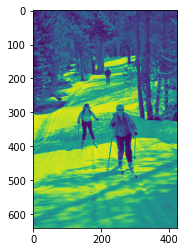

In [9]:
for i in ds.take(1):
    plt.imshow(i)

In [10]:
yogadl_dataset = make_yogadl_dataset(ds) # use yogadl for caching and shuffling the data

In [11]:
from src.data import load_M51

In [12]:
x = load_M51()

In [27]:
y.shape


TensorShape([1, 300])

In [12]:
def meas(x, m_op, ISNR):
    x = tf.reshape(x, [1, x.shape[0], x.shape[1]])
    y0 = m_op.dir_op(x)
    sigma = tf.math.sqrt(tf.math.reduce_mean(tf.math.abs(y0)**2)) * 10**(-ISNR/20)
    n = np.random.normal( 0, sigma, data_shape) + 1j * np.random.normal( 0, sigma, data_shape)
    y = y0 + n

In [ ]:
def measurement(x, m_op, ISNR, data_shape, Nd=(256,256)):
    """Creates measurement from image, adds measurement noise,
    returns measurement, true image"""
    y0 = m_op.dir_op(x.reshape(1, Nd[0], Nd[1]))

    sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
    n = np.random.normal( 0, sigma, data_shape) + 1j * np.random.normal( 0, sigma, data_shape)
    y = y0 + n

    y_dirty = y
    return y_dirty.reshape(data_shape).astype(np.complex64), x.reshape(Nd).astype(np.float32)


def measurement_func(uv, m_op = None, data_shape=None, Nd=(256,256), ISNR=30):
    """function for getting a tf function version of the measurment function"""
    if data_shape is None:
        data_shape = (len(uv),)

    # TODO handle this operator neatly
    if m_op is None:
        m_op = NUFFT2D()
        m_op.plan(uv, (Nd[0], Nd[1]), (Nd[0]*2, Nd[1]*2), (6,6))
        m_op_tf = NUFFT2D_TF()
        m_op_tf.plan(uv, (Nd[0], Nd[1]), (Nd[0]*2, Nd[1]*2), (6,6), 20)


    func = partial(measurement, m_op=m_op, ISNR=ISNR, data_shape=data_shape, Nd=Nd)

    @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
    def tf_function(x):
        return tf.numpy_function(func, [x], (tf.complex64, tf.float32))

    
    return tf_function, func


In [13]:
def measure(x):
    x = tf.reshape(x, [1, x.shape[0], x.shape[1]])

    y0 = m_op_tf.dir_op(x)
    sigma = tf.cast(tf.math.sqrt(tf.math.reduce_mean(tf.math.abs(y0)**2)) * 10**(-ISNR/20), tf.float32)

    n = tf.cast( tf.random.normal( y0.shape, stddev=sigma), dtype=tf.complex64) + 1j * tf.cast( tf.random.normal( y0.shape, stddev=sigma), dtype=tf.complex64)
    y = y0 + n
    return y[0], x[0]

In [22]:
import numpy as np

In [23]:
m_op_tf = NUFFT2D_TF()
m_op_tf.plan(uv, (256, 256), (512, 512), (6,6), 20)

100%|██████████| 32768/32768 [00:05<00:00, 6262.64it/s]


some values lie out of the interpolation array, these are not used, check baselines


In [24]:
x = np.array([x for i in range(20)])

In [28]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In [25]:
%%time
a = m_op.dir_op(x)

CPU times: user 4.42 s, sys: 3.12 s, total: 7.53 s
Wall time: 7.6 s


In [30]:
%%time
a = m_op.dir_op(x[0])

CPU times: user 231 ms, sys: 15.8 ms, total: 247 ms
Wall time: 262 ms


In [31]:
.262*20

5.24

In [29]:
%%time
with tf.device("CPU:0"):
    a = m_op_tf.dir_op(x)

2022-03-22 15:54:50.590269: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at gather_nd_op.cc:47 : INVALID_ARGUMENT: indices[23572739] = [19, 139, -1] does not index into param shape [20,512,512], node name: GatherNd


InvalidArgumentError: indices[23572739] = [19, 139, -1] does not index into param shape [20,512,512], node name: GatherNd [Op:GatherNd]

In [17]:

# creates
data_map = partial(data_map, y_size=y_shape, z_size=(256,256))
dataset = yogadl_dataset.map(random_crop).map(measure).batch(20).map(data_map).prefetch(tf.data.experimental.AUTOTUNE)


In [18]:
%%time
for i in dataset.take(1):
    a = i[0].shape
    pass

2022-03-22 15:50:49.959332: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at gather_nd_op.cc:47 : INVALID_ARGUMENT: indices[1159427] = [0, 139, -1] does not index into param shape [1,512,512], node name: GatherNd


InvalidArgumentError: indices[1159427] = [0, 139, -1] does not index into param shape [1,512,512], node name: GatherNd
	 [[{{node GatherNd}}]] [Op:IteratorGetNext]

In [19]:
dataset = yogadl_dataset.map(random_crop).map(tf_func).batch(20).map(data_map).prefetch(tf.data.experimental.AUTOTUNE)


2022-03-22 15:50:50.191238: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at gather_nd_op.cc:47 : INVALID_ARGUMENT: indices[1159427] = [0, 139, -1] does not index into param shape [1,512,512], node name: GatherNd
2022-03-22 15:50:50.366167: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at gather_nd_op.cc:47 : INVALID_ARGUMENT: indices[1159427] = [0, 139, -1] does not index into param shape [1,512,512], node name: GatherNd
2022-03-22 15:50:50.516241: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at gather_nd_op.cc:47 : INVALID_ARGUMENT: indices[1159427] = [0, 139, -1] does not index into param shape [1,512,512], node name: GatherNd


In [20]:
%%time
for i in dataset.take(1):
    a = i[0].shape
    pass

2022-03-22 15:50:50.667079: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at gather_nd_op.cc:47 : INVALID_ARGUMENT: indices[1159427] = [0, 139, -1] does not index into param shape [1,512,512], node name: GatherNd


CPU times: user 3.71 s, sys: 658 ms, total: 4.37 s
Wall time: 4.41 s


In [14]:
for i in dataset.take(2):
    print(i[0].shape, i[1].shape) # [batch_size, n_measurments], [batch_size, Nd[0], Nd[1]]
    plt.plot(i[0][0])
    plt.show()
    plt.imshow(i[1][0].numpy().real)
    plt.colorbar()
    plt.show()

2022-03-22 15:00:25.905661: W tensorflow/core/framework/op_kernel.cc:1733] UNKNOWN: AttributeError: 
        'EagerTensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
Traceback (most recent call last):

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/home/mars/src_aiai/src/dataset.py", line 143, in measurement
    return y_dirty.reshape(data_shape).astype(np.complex64), x.reshape(Nd).astype(np.float32)

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 437, in __getattr__
    raise AttributeError("""

AttributeError: 
      

UnknownError: AttributeError: 
        'EagerTensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
Traceback (most recent call last):

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/home/mars/src_aiai/src/dataset.py", line 143, in measurement
    return y_dirty.reshape(data_shape).astype(np.complex64), x.reshape(Nd).astype(np.float32)

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 437, in __getattr__
    raise AttributeError("""

AttributeError: 
        'EagerTensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()


	 [[{{function_node __inference_tf_function_133}}{{node PyFunc}}]] [Op:IteratorGetNext]

2022-03-22 15:00:26.119207: W tensorflow/core/framework/op_kernel.cc:1733] UNKNOWN: AttributeError: 
        'EagerTensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()
Traceback (most recent call last):

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/home/mars/src_aiai/src/dataset.py", line 143, in measurement
    return y_dirty.reshape(data_shape).astype(np.complex64), x.reshape(Nd).astype(np.float32)

  File "/home/mars/.local/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 437, in __getattr__
    raise AttributeError("""

AttributeError: 
      